In [8]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import datetime
import scipy
import os
from tqdm.notebook import tqdm
import time
import sys

import VVSAnalyzer
import MBTAnalyzer
import vid2vib_utils
import spectra_utils
import aggregate_utils
import plotting_utils
import accelerometer_utils

## Site Specific Parameters

In [2]:
# video to process
vid_num = '5486'

# parametrized path
vid_path = f'../TreeSwayData/sidneytrees/videos/SidneyTrees_30s_{vid_num}.MP4'

# dictionary storing datetimes for each video
vid_datetimes = {'5486' : '2020-8-15 12:06',
                 '5731' : '2020-8-20 17:28',
                 '6236' : '2020-8-31 11:50'}

# dictionary storing rois
rois = {'w293' : [420, 520, 395, 445],
        'control460' : [400, 575, 690, 760],
        'region1' : [336, 732, 200, 904]}

# roi to analyze
roi = 'w293'

# directory to store output (optional)
out_prefix = f'./output/manitou_{vid_num}_{roi}'

## Video Processing Parameters

In [3]:
# VSS video translation kwargs
vid2vib_pa_kwargs = {'reduction':'gray', 'verbose':False}

# MBT video translation kwargs
vid2vib_mbt_kwargs = {'reduction':'gray'}
nlevels = 8

# upper and lower bound of candidate frequencies
freqmin = 0.15
freqmax = 0.5

# function and kwargs used to estimate PSD
spectra_func = spectra_utils.get_spectra_periodogram
spectra_func_kwargs = {'window':'boxcar', 'nfft':4096, 'verbose':False}

# function and kwargs used to find dominant frequency in each spectrum
dom_freq_func = spectra_utils.get_dom_freq_peak_finder
dom_freq_func_kwargs = {}

# masking parameters
percentile=75
masks = [{'name':f'Prominence, {percentile}th percentile',
          'weight':'prominence',
          'kwargs':{'stat_reduc':'percentile', 'percentile':percentile}}, 
        ]

# plotting figure size
figsize=(14,7)

## VVS

In [4]:
vvs = VVSAnalyzer.VVSAnalyzer(vid_path, rois[roi])

In [5]:
vib_vvs, fps = vvs.vid2vib(vid2vib_pa_kwargs)

Reading video into array
902
Finished reading video into array


In [6]:
freq_vvs, pxx_vvs = vvs.compute_spectra(freqmin, freqmax, spectra_func, spectra_func_kwargs)

Computing pixel spectra
Finished computing spectra


In [7]:
agg_df_vvs, pxx_avg_vvs, pxx_avg_peak_idx_vvs, dom_freq, masked, masked_avg_spectrums, masked_avg_spectrums_peak_idxs = vvs.aggregate(dom_freq_func, dom_freq_func_kwargs, masks)

,unmasked_avg_spectrum_peak,unmasked_mode,mask0_avg_spectrum_peak,mask0_mode
0,0.276123,0.276123,0.276123,0.276123


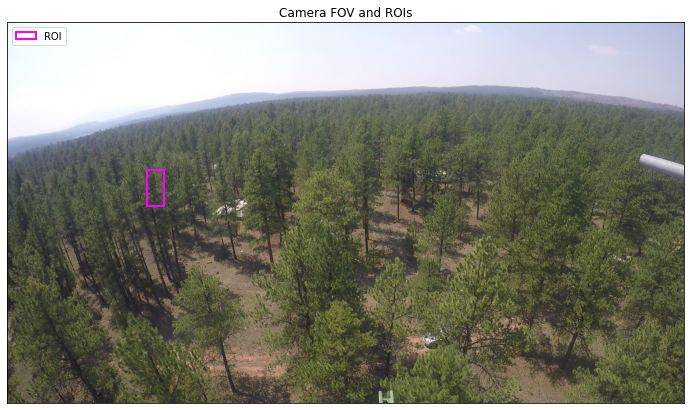

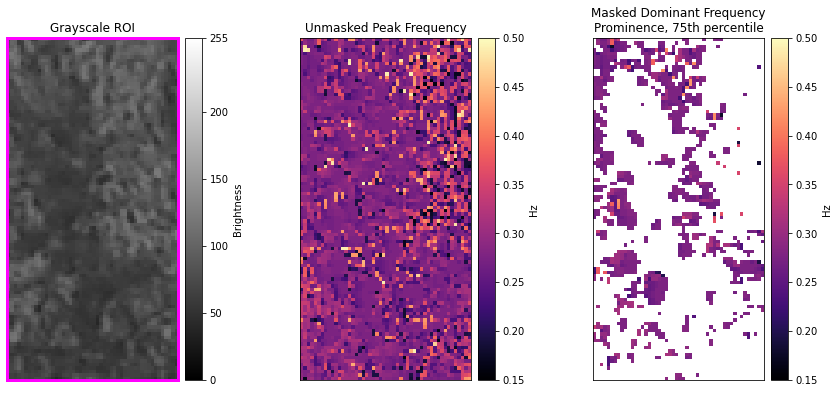

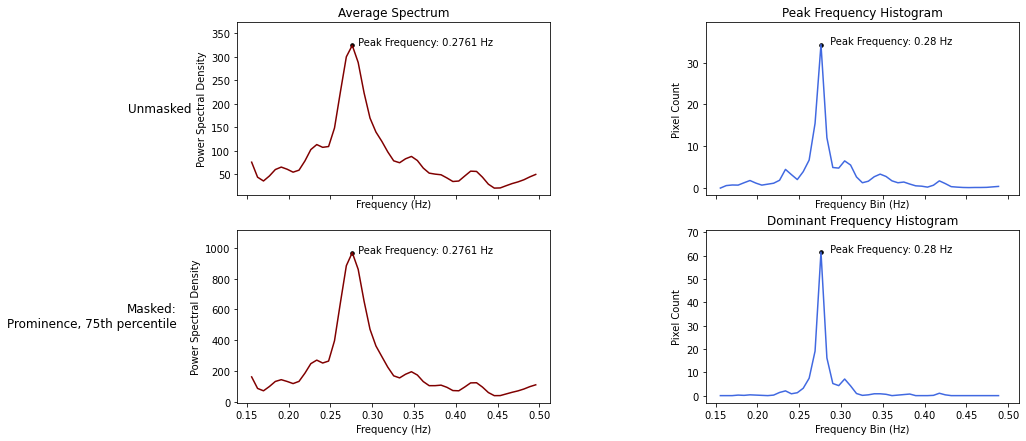

In [8]:
vvs.report(figsize=figsize)

## VVS Batch Processing

In [4]:
num_vids = 9

#vids = [30 + i for i in range(num_vids)]
vids = [5917]

vid_dir = '../TreeSwayData/sidneytrees/batch_0831/'

vid_paths = sorted(os.listdir(vid_dir))

datetimes = [vid2vib_utils.get_video_datetime(vid_dir + p) for p in vid_paths]

In [9]:
avg = []
mode = []
avg_prom = []

dt = []

for i, v in enumerate(vid_paths):
    path = vid_dir + v
    
    start_time = time.time()
    
    vvs = VVSAnalyzer.VVSAnalyzer(path, rois[roi])
    vib_vvs, fps = vvs.vid2vib(vid2vib_pa_kwargs)
    freq_vvs, pxx_vvs = vvs.compute_spectra(freqmin, freqmax, spectra_func, spectra_func_kwargs)
    agg_df_vvs, pxx_avg_vvs, pxx_avg_peak_idx_vvs, dom_freq, masked, masked_avg_spectrums, masked_avg_spectrums_peak_idxs = vvs.aggregate(dom_freq_func, dom_freq_func_kwargs, masks)
    
    pxx_avg_vvs_norm = spectra_utils.normalize(pxx_avg_vvs, freq_vvs[1] - freq_vvs[0])
    pxx_avg_peak_idx, pxx_avg_peak_mag, pxx_avg_peak_prom = spectra_utils.find_dominant_peak(pxx_avg_vvs_norm)
    avg_prom.append(pxx_avg_peak_prom)
    
    avg.append(agg_df_vvs['mask0_avg_spectrum_peak'][0])
    mode.append(agg_df_vvs['mask0_mode'][0])
    
    end_time = time.time()
    dt.append(end_time - start_time)
    
    estimated_remaining = np.mean(dt) * (num_vids - (i + 1)) / 60
    
    sys.stdout.write('\r{0}'.format(estimated_remaining) + ' minutes remaining')
    sys.stdout.flush()

0.0 minutes remaininginutes remaining

In [17]:
swayfreq_df = pd.DataFrame({'average_spectrum_peak':avg, 'average_spectrum_peak_prominence':avg_prom, 'mode_peak':mode}, index=datetimes)
swayfreq_df

,average_spectrum_peak,average_spectrum_peak_prominence,mode_peak
2020-08-31 08:46:15,0.283203,0.012657,0.219482
2020-08-31 09:16:56,0.269043,2.821186,0.269043
2020-08-31 09:47:36,0.297363,2.584212,0.297363
2020-08-31 10:18:18,0.283203,4.291087,0.283203
2020-08-31 10:48:58,0.283203,6.186885,0.290283
2020-08-31 11:19:39,0.283203,20.708160,0.283203
2020-08-31 11:50:20,0.304443,3.310476,0.297363
2020-08-31 12:20:59,0.290283,8.749822,0.290283
2020-08-31 12:51:42,0.247803,3.156148,0.283203
2020-08-31 13:22:23,0.269043,8.799096,0.269043


<AxesSubplot:>

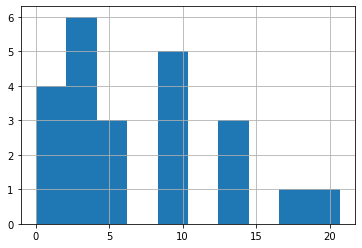

In [38]:
swayfreq_df['average_spectrum_peak_prominence'].hist(bins=10)

Text(0, 0.5, 'Prominence')

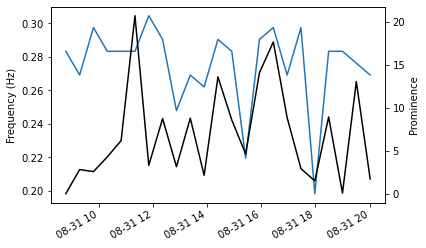

In [19]:
fig, ax = plt.subplots()

swayfreq_df['average_spectrum_peak'].plot(ax=ax)
ax.set_ylabel('Frequency (Hz)')

ax2=ax.twinx()
swayfreq_df['average_spectrum_peak_prominence'].plot(ax=ax2, c='k')
ax2.set_ylabel('Prominence')

<AxesSubplot:>

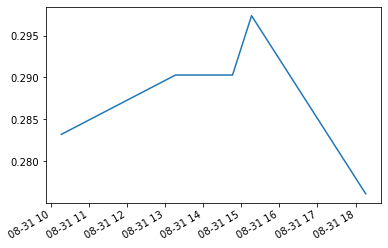

In [44]:
prom_threshold = 10
swayfreq_masked_df = swayfreq_df[swayfreq_df['average_spectrum_peak_prominence'] > prom_threshold]
swayfreq_masked_df['average_spectrum_peak'].plot()

In [ ]:
plt.scatter(datetimes[0], mode[1:])

## MBT

In [ ]:
mbt = MBTAnalyzer.MBTAnalyzer(vid_path, rois[roi], nlevels, out_prefix)

In [ ]:
vib_mbt, _, levels = mbt.vid2vib(vid2vib_mbt_kwargs)

In [ ]:
freq_mbt, pxx_mbt = mbt.compute_spectra(freqmin, freqmax, spectra_func, spectra_func_kwargs)

In [ ]:
agg_df_mbt, pxx_avg_mbt, pxx_avg_peak_idx_mbt = mbt.aggregate(dom_freq_func, dom_freq_func_kwargs, masks)

In [ ]:
mbt.report(figsize=figsize)